# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>




**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
#reading the data and looking at the top few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
#finding the number of rows
n_rows = df.shape[0]
print('The numebr of rows in the dataset is: {}'.format(n_rows))

The numebr of rows in the dataset is: 294478


**c.** The number of unique users in the dataset.

In [4]:
#number of unique users
unique = df.user_id.nunique()
print('The numebr unique users is: {}'.format(unique))

The numebr unique users is: 290584


**d.** The proportion of users converted.

In [5]:
#finding the proportion of users converted
p_conv = df.query("converted == 1").user_id.count() / df.shape[0]
print('The proportion of users converted is: {}'.format(p_conv))

The proportion of users converted is: 0.11965919355605512


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
#checking the number of times when the "group" is "treatment" but "landing_page" is not a "new_page"
treatment_mismatch = df.query("group == 'treatment' and landing_page != 'new_page'").user_id.count()
print('The number of times when the "group" is "treatment" but "landing_page" is not a "new_page" is {} times'.format(treatment_mismatch))

The number of times when the "group" is "treatment" but "landing_page" is not a "new_page" is 1965 times


**f.** Do any of the rows have missing values?

In [7]:
#checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing values were found.

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#getting the inaccurate rows where there is a mismatch between the group and the landing page
dff = df.query("(group == 'control' and landing_page == 'new_page') or (group == 'treatment' and landing_page == 'old_page')")
dff.head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


In [9]:
# Removing the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(dff.index, axis = 0)

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

All inaccurate rows were removed.

### ToDo 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [11]:
#getting the unique user_ids in the new dataframe df2
new_unique = df2.user_id.nunique()
print('The number of unique user_ids in the new dataframe is: {}'.format(new_unique))

The number of unique user_ids in the new dataframe is: 290584


**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
repeated_userid = df2[df2.duplicated(subset = 'user_id')]['user_id'].iloc[0]
repeated_userid
print('The repeated user id is: {}'.format(repeated_userid))

The repeated user id is: 773192


**c.** Display the rows for the duplicate **user_id**? 

In [13]:
#displaying the rows with the duplicate user_id
df2[df2.duplicated(subset = 'user_id', keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Two rows were found, one of them should be deleted.

**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop_duplicates(subset = 'user_id', inplace = True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(subset = 'user_id')]

,user_id,timestamp,group,landing_page,converted


In [15]:
#another check, matching the count of user_id column with the unique count of user_id column. It should return "True"
df2.user_id.count() == df2.user_id.nunique()

True

### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [16]:
#rechecking the new dataframe
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [17]:
#probability of converting (p_population)
p_population = df2[df2['converted'] == 1].converted.count() / df2.shape[0]
print("The probability of an individual converting regadless of the page they receive is: {}".format(p_population))

The probability of an individual converting regadless of the page they receive is: 0.11959708724499628


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
#getting the counts of people who converted grouped by "group" to calculate the upcoming probabilites. 
cts = df2.groupby('group').converted.value_counts()
cts

group      converted
control    0            127785
           1             17489
treatment  0            128046
           1             17264
Name: converted, dtype: int64

In [19]:
#probability of converting from a control group
conv_ctrl = cts['control'][1] / cts['control'].sum()
print("The conversion rate in a control group is: {}".format(conv_ctrl))

The conversion rate in a control group is: 0.1203863045004612


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
#probability of converting from a treatment group
conv_trmnt = cts['treatment'][1] /cts['treatment'].sum()
print("The conversion rate in a treatment group is: {}".format(conv_trmnt))

The conversion rate in a treatment group is: 0.11880806551510564


In [21]:
# Calculating the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = conv_trmnt - conv_ctrl 
print("The difference between the conversion rates for the two groups is: {}".format(obs_diff))

The difference between the conversion rates for the two groups is: -0.0015782389853555567


**d.** What is the probability that an individual received the new page?

In [22]:
#calculating the probability that an individual receive the new page.
p_new_page = df2[df2['landing_page'] == 'new_page'].landing_page.count() / df2.shape[0]
print("The probability of receiving a new page is: {}".format(p_new_page))

The probability of receiving a new page is: 0.5000619442226688


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>As we can see, based on these rates, the treatment group users didn't lead to more conversions. In fact, the conversion rate from a control group is slightly greater than the rate from a treatement group with a value of 0.00158. We will need to perform and A/B Test.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.


><center>
$H_0: p_{new} - p_{old} \leq 0$  
</center><center>
$H_1: p_{new} - p_{old} > 0 $  
</center>

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 




In [23]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [24]:
#conversion rate for p_new under the null
p_new = p_population
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [25]:
#conversion rate for p_old under the null
p_old = p_population
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [28]:
#number of individuals in the treatment group
n_new = df2[df2['group'] == 'treatment'].group.count()
print("The number of individauls in the treatment group is: {}".format(n_new))

The number of individauls in the treatment group is: 145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [29]:
#number of individuals in the control group
n_old = df2[df2['group'] == 'control'].group.count()
print("The number of individauls in the control group is: {}".format(n_old))

The number of individauls in the control group is: 145274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
We will use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [30]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, 1-p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [31]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0], size = n_old, p = [p_old, 1-p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [32]:
p_new_prime = new_page_converted.mean()
p_old_prime = old_page_converted.mean()
conv_diff = p_new_prime - p_old_prime
conv_diff

0.0006517462434614957


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [33]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, 1-p_new]) #sample for new page conversion
    old_page_converted = np.random.choice([1,0], size = n_old, p = [p_old, 1-p_old]) #sample for old page conversion
    p_new_prime = new_page_converted.mean() #conversion rate from new page
    p_old_prime = old_page_converted.mean() #conversion rate from old_page
    conv_diff = p_new_prime - p_old_prime #difference
    p_diffs.append(conv_diff) #appending data to the list

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  



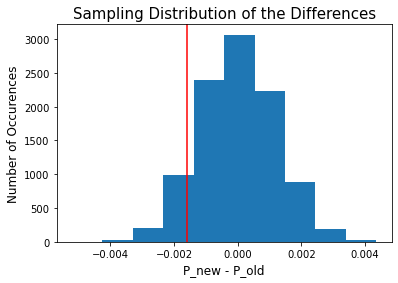

In [34]:
# Creating a histogram for the sampling distribution
plt.hist(p_diffs)
plt.title('Sampling Distribution of the Differences', fontsize = 15)
plt.xlabel('P_new - P_old', fontsize = 12)
plt.ylabel('Number of Occurences', fontsize = 12)
plt.axvline(obs_diff, color = 'r')
plt.show()

In [35]:
#Simulating from the null using normal distribution
null_vals = np.random.normal(0, np.std(p_diffs), 10000)

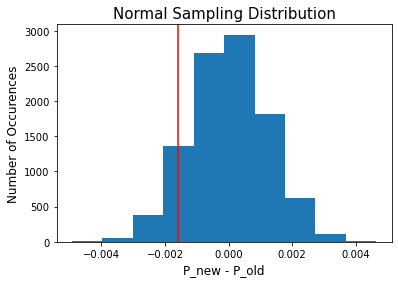

In [37]:
#plotting a histogram for the normal distribution
plt.hist(null_vals)
plt.title('Normal Sampling Distribution', fontsize = 15)
plt.xlabel('P_new - P_old', fontsize = 12)
plt.ylabel('Number of Occurences', fontsize = 12)
plt.axvline(obs_diff, color = 'r')
plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [38]:
p_value = (null_vals > obs_diff).mean()
p_value

0.9067

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 


>The value I just computed above is called the p-value. The p_value is the probability of observing our statistic (here the proportions difference) or one more extreme in favor of the alternative, given that the null is true. Based on the chosen Type I error rate, also called "alpha", here 0.05, we have two possible conclusions.  
>- If the p_value is greater than "alpha", then we fail to reject the null hypothesis.  
>- If the p_value is less than or equal to "alpha", then we reject the null in favor of the alternative.  

>In this test, the p_value is 0.9 which is greater than 0.05, therefore, we fail to reject the null.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [39]:
#checking the dataframe
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [40]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = n_old

# number of individuals who received new_page
n_new = n_new

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.


For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$.  
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 



In [41]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>- For a $Z_{score}$ of $-1.31$, and a right-tailed test, this means that we fail to reject the null, because we only reject the null if $Z_{score}$ > $Z_{\alpha}$ and for our test (one-tailed test), $Z_{\alpha} = 1.645$, therefore, we fail to reject the null. In relation to conversion rates, this means, that, based on the test done, the conversion rates of the old pages are less than or equal to the conversions from the new pages.
>- As for the p_value, it is almost the same as the p_value computed in part j. So, the p_value is still greater than type I error rate (0.05), $\alpha = 0.05$, therefore, we still fail to reject the null.


<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>We should use logistic regression.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [42]:
#creating intercept column
df2['intercept'] = 1
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1


In [43]:
#creating dummy column
df2['ab_page'] = pd.get_dummies(df2['group'], drop_first = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [44]:
# fitting the model
logim = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logim.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [45]:
#providing model summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-03-24 00:32 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


  
>- The p_value associated with ab_page is 0.1899. The p_value here indicates whether the independant variables, (here: intercept and ab_page i.e. the treatment or new page), used to predict the dependant variable (here: converted i.e. conversion rate), is statistically significant or not.  
>- The reason it is different from the value found in part II because the null and alternative hypotheses in each part are different.  
>- In part II, it was a one sided test $H_0: p_{new} - p_{old} \leq 0$ and  $H_1: p_{new} - p_{old} > 0.$  
>- Coming to part III, it's a two sided test because it tests whether the variable is statistically significant or not to predict the result variable.  
>- The current p_value (0.1899) is greater than Type I error (0.05) which means that we fail to reject the null and the explatory variable (new page) used is not statistically significant to predict the response variable (conversion rate). 

 

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>Adding other factors to the regression model helps in having better interpretations and predictions. It helps getting better results from different angles(the other factors). Although the previous advantages, we need to be careful when adding more factors, because there may be a correlation between explatory variables compared to each other which gives irrelevant, and sometimes counter intuitive, results. Also, if the added factor is not relevant the response variable, it will affect the results of our model.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`.  

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
We will se `pandas.get_dummies()` to create dummy variables. 

 Provide the statistical output as well as a written response to answer this question.

In [46]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
# Join with the df2 dataframe
df_merged = pd.merge(df2, countries, on = 'user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [48]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [49]:
#creating a model to add the country effect
logim2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'UK']])
result2 = logim2.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-03-24 00:38 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

>Still, all the p_values are greater than type I error (0.05). Therefore, we still fail to reject the null and hence, it doesn't appear that the country has an impact on conversion.

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Here we will provide the summary results (statistical output), and the conclusions (written response) based on the results. 


In [50]:
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [51]:
#creating additional columns to show interaction between page and country
df_merged['US_ab_page'] = df_merged['ab_page'] * df_merged['US'] # interaction between the new page and US
df_merged['UK_ab_page'] = df_merged['ab_page'] * df_merged['UK'] # interaction beween the new page and UK
df_merged.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_ab_page,UK_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,0,0


In [52]:
# Fitting the new model, and summarizing the results
logim3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page']])
result3 = logim3.fit()
result3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-03-24 00:40 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

>After examining all the p_values, we found that all of them are greater than type I error (0.05). Therefore, there is no statistical significance in using any of these factors to predict the conversion rate based on the new page. In this particular case, adding interactions between the page and the country didn't help and we failed to reject the null. 

## Final Conculusion

We failed to reject the null based on the data provided. We tried different approaches such as bootstraping and sampling distribution and logistic regression however all of them showed that we fail to reject the null, meanining that the effect of the new page landing page is not statistically significant to the conversion rate.